In [2]:
import Net
from dpf import *

utils.fix_rng(10)
model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
sim_object.save('./data/polya', 50, 20, '')

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [17]:
print(pt.arange(2).tile((3, 1))[pt.tensor([[True, False], [False, True], [True, False]])])

tensor([0, 1, 0])


In [ ]:
from dpf import *
from dpf import training
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from trainingRS import e2e_train


loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
data = model.State_Space_Dataset('./data/polya', lazy = True, device='cuda', num_workers=0)
utils.fix_rng(9)
#train_model = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Boot'), 'Boot', 'cuda')
train_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
DPF = simulation.Differentiable_Particle_Filter(train_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
#opt = pt.optim.SGD(DPF.parameters(), lr=0.05, momentum=0.9)
#opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [10, 20, 30, 40, 50], gamma=0.5)
opt = pt.optim.AdamW(DPF.parameters(), lr=0.05, weight_decay=0.05)
result = e2e_train(DPF, opt, loss, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 60, 10, None, True)

In [ ]:
from dpf import *
from dpf import training
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from trainingRS import e2e_likelihood_train


def run(grad_scale, softness):
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/polya', lazy = True, device='cuda', num_workers=0)
    utils.fix_rng(11)
    train_model = Net.Redefined_RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    valid_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Boot', 'cuda'), 'Boot', 'cuda')
    DPF = simulation.Differentiable_Particle_Filter(train_model, 200, Soft_Resampler_Systematic(softness, grad_scale), 200, 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.AdamW(DPF.parameters(), lr=0.05)
    return e2e_likelihood_train(DPF, DPF_valid, opt, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 60 ,10, None, False)

utils.grid_search(run, {'softness': [0.5, 0.8, 1], 'grad_scale': [1, 0.9, 0.5]})

In [5]:
print(np.stack((np.arange(10), np.arange(10))).shape)

(2, 10)


In [ ]:
from dpf import *
from dpf import training
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from trainingRS import e2e_likelihood_train, e2e_train
import pickle

utils.fix_rng(0)
def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    train_model = Net.Redefined_RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    valid_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    DPF = simulation.Differentiable_Particle_Filter(train_model, 200, Soft_Resampler_Systematic(0.5, 1), 200, 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.AdamW(DPF.parameters(), lr=0.05, weight_decay=0.05)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [20, 30, 40, 45], 0.5)
    return e2e_likelihood_train(DPF, DPF_valid, opt, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 50 ,10, None, False)

dic = utils.aggregate_runs(run, 20, ['loss', 'per_step_loss'])
print(dic)
with open('./results/PolyaRLPF2.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.fix_rng(0)
def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    train_model = Net.Redefined_RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    valid_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    DPF = simulation.Differentiable_Particle_Filter(train_model, 200, Soft_Resampler_Systematic(0.5, 1), 200, 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.AdamW(DPF.parameters(), lr=0.05, weight_decay=0.05)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [20, 30, 40, 45], 0.5)
    return e2e_likelihood_train(DPF, DPF_valid, opt, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 50 ,10, opt_sch, False)

dic = utils.aggregate_runs(run, 20, ['loss', 'per_step_loss'])
print(dic)
with open('./results/MarkovRLPF2.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.fix_rng(0)
def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    valid_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.AdamW(DPF_valid.parameters(), lr=0.02, weight_decay=0.05)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [20, 30, 40, 45], 0.5)
    return e2e_train(DPF_valid, opt, loss, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 80, 10, None, False)

dic = utils.aggregate_runs(run, 20, ['loss', 'per_step_loss'])
print(dic)
with open('./results/PolyaRLPF-b.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.fix_rng(0)
def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    valid_model = Net.RSDBPF(8, Net.NN_Switching(8, 8, 'Uni', 'cuda'), 'Uni', 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.AdamW(DPF_valid.parameters(), lr=0.02, weight_decay=0.05)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [20, 30, 40, 45], 0.5)
    return e2e_train(DPF_valid, opt, loss, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 80, 10, None, False)

dic = utils.aggregate_runs(run, 20, ['loss', 'per_step_loss'])
print(dic)
with open('./results/MarkovRLPF-b.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import numpy as np
files = ['DBPF-Polya-20', 'DBPF-Markov-20', 'RSDBPF_Markov']
for i in range(3):
    with open(f'./results/{files[i]}.pickle', 'rb') as handle:
        dic = pickle.load(handle)
    losses = dic['loss']['raw'].flatten()
    sort_losses = np.sort(losses)
    print(sort_losses)
    print(np.mean(sort_losses))


[2.6669464 2.9594018 3.0646014 3.2208297 3.3962476 3.7994552 4.0341916
 4.112954  4.1857786 4.186938  4.2849054 4.3870296 4.387716  4.5169787
 4.642875  4.680869  4.7909765 4.8373117 5.1632605 5.1727214]
4.1245995
[ 4.147045 10.200166 10.227438 11.296034 11.550023 11.73395  12.101888
 12.107229 13.613815 14.869781 15.106461 15.886956 17.96302  18.872086
 19.210976 19.805014 20.459532 20.504004 21.040792 23.007885]
15.185205
[0.8743931  0.98321587 1.0009173  1.0358711  1.2907372  1.3933729
 1.4032993  1.6204218  1.6893649  1.7458528  1.8322039  2.108273
 2.1354184  2.2483883  2.5361073  2.8366957  3.0308824  3.0826237
 3.1089723  3.4327176 ]
1.9694862


In [ ]:
from dpf import *
from dpf import training
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from trainingRS import e2e_train
import pickle

def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    valid_model = Net.RSDBPF(8, Net.Polya_Switching(8, 'Boot', 'cuda'), 'Boot', 'cuda')
    DPF_valid = simulation.Differentiable_Particle_Filter(valid_model, 200, Soft_Resampler_Systematic(1, 0), 200, 'cuda')
    opt = pt.optim.SGD(DPF_valid.parameters(), lr=0.05, momentum=0.9)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [10, 20, 30, 40, 50], gamma=0.5)
    #opt = pt.optim.AdamW(DPF_valid.parameters(), lr=0.05)
    return e2e_train(DPF_valid, opt, loss, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 60, 10, opt_sch, False)

dic = utils.aggregate_runs(run, 3, ['loss', 'per_step_loss'])
print(dic)
with open('./results/PolyaRSDBPF.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
from Net import Transformer, Polya_Switching, PF, LSTM
from dpf import model
from trainingRS import train_s2s
from dpf import utils
import torch as pt

def run():
    #model_ = PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
    #sim_object = model.Simulated_Object(model_, 100, 50, 1, 'cuda')
    #sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    #NN = Transformer(1, 12, 1, 50, 'cuda')
    NN = LSTM(1, 20, 1, 2)
    opt = pt.optim.AdamW(NN.parameters(), lr=0.05, weight_decay=0.005)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [10, 20, 30, 40, 50], gamma=0.5)
    return train_s2s(NN, opt, data, [100, -1, -1], [0.5, 0.25, 0.25], 50, None, True, 10)

dic = utils.aggregate_runs(run, 3, ['loss', 'per_step_loss'])
print(dic)
with open('./results/Transformer.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Epoch 0:
Train loss: 9.065106678009034
Validation loss: 6.742320537567139



100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Epoch 1:
Train loss: 4.633397102355957
Validation loss: 3.152226209640503



100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Epoch 2:
Train loss: 2.9342453718185424
Validation loss: 2.4426920413970947



100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Epoch 3:
Train loss: 2.1838589549064635
Validation loss: 1.9946863651275635



100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch 4:
Train loss: 1.8271053791046143
Validation loss: 1.7042975425720215



100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Epoch 5:
Train loss: 1.6127293944358825
Validation loss: 1.5509617328643799



100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch 6:
Train loss: 1.4703597187995912
Validation loss: 1.4393751621246338



100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


Epoch 7:
Train loss: 1.350286853313446
Validation loss: 1.3010567426681519



100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Epoch 8:
Train loss: 1.2522853016853333
Validation loss: 1.259517788887024



100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch 9:
Train loss: 1.1879112660884856
Validation loss: 1.1486965417861938



100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch 10:
Train loss: 1.0761866867542267
Validation loss: 1.074440598487854



100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch 11:
Train loss: 1.0064078390598297
Validation loss: 1.010737657546997



100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


Epoch 12:
Train loss: 0.9553295016288758
Validation loss: 0.9477148056030273



100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Epoch 13:
Train loss: 0.9333197772502899
Validation loss: 0.9627183675765991



100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Epoch 14:
Train loss: 0.9315981686115264
Validation loss: 0.8999049067497253



100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


Epoch 15:
Train loss: 0.8949780821800232
Validation loss: 0.9036364555358887



100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch 16:
Train loss: 0.8669553875923157
Validation loss: 0.8498474359512329



100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch 17:
Train loss: 0.8646330535411835
Validation loss: 0.8649056553840637



100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Epoch 18:
Train loss: 0.8823952674865723
Validation loss: 0.8697115778923035



100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Epoch 19:
Train loss: 0.8567545771598816
Validation loss: 0.8452594876289368



100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Epoch 20:
Train loss: 0.8216822862625122
Validation loss: 0.8032459616661072



100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Epoch 21:
Train loss: 0.7907656311988831
Validation loss: 0.8082947731018066



100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Epoch 22:
Train loss: 0.7730448961257934
Validation loss: 0.778106153011322



100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Epoch 23:
Train loss: 0.7571217298507691
Validation loss: 0.7522842288017273



100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch 24:
Train loss: 0.7478448390960694
Validation loss: 0.784171462059021



100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Epoch 25:
Train loss: 0.7633912801742554
Validation loss: 0.7604067921638489



100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch 26:
Train loss: 0.7744569778442383
Validation loss: 0.7805092334747314



100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Epoch 27:
Train loss: 0.7497701108455658
Validation loss: 0.7701576352119446



100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Epoch 28:
Train loss: 0.7404975116252899
Validation loss: 0.7265700697898865



100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Epoch 29:
Train loss: 0.7183215320110321
Validation loss: 0.7506336569786072



100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch 30:
Train loss: 0.7271891951560974
Validation loss: 0.7124930620193481



100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch 31:
Train loss: 0.7690325856208802
Validation loss: 0.7336432933807373



100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Epoch 32:
Train loss: 0.7499897718429566
Validation loss: 0.7813469171524048



100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch 33:
Train loss: 0.7530852973461151
Validation loss: 0.782039225101471



100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch 34:
Train loss: 0.7314909398555756
Validation loss: 0.7006623148918152



100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch 35:
Train loss: 0.7068475008010864
Validation loss: 0.6910344958305359



100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Epoch 36:
Train loss: 0.6842356383800506
Validation loss: 0.7028841376304626



100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Epoch 37:
Train loss: 0.6825559616088868
Validation loss: 0.6854223608970642



100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


Epoch 38:
Train loss: 0.6787465810775757
Validation loss: 0.7124390006065369



100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch 39:
Train loss: 0.6661660432815552
Validation loss: 0.6783212423324585



100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch 40:
Train loss: 0.6739970505237579
Validation loss: 0.6820798516273499



100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch 41:
Train loss: 0.7068523585796356
Validation loss: 0.6977332234382629



100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Epoch 42:
Train loss: 0.7068786442279815
Validation loss: 0.7026103138923645



100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Epoch 43:
Train loss: 0.6935895025730133
Validation loss: 0.7033077478408813



100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Epoch 44:
Train loss: 0.6880371809005738
Validation loss: 0.6899813413619995



100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Epoch 45:
Train loss: 0.6764973640441895
Validation loss: 0.6949247717857361



100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Epoch 46:
Train loss: 0.6728169679641723
Validation loss: 0.6881828308105469



100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch 47:
Train loss: 0.6821439981460571
Validation loss: 0.6943157315254211



100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


Epoch 48:
Train loss: 0.6809070229530334
Validation loss: 0.7197558283805847



100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Epoch 49:
Train loss: 0.6662707448005676
Validation loss: 0.6719045639038086



 33%|███▎      | 1/3 [01:58<03:57, 118.53s/it]

Test loss: 0.6508042216300964


100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


Epoch 0:
Train loss: 7.315948176383972
Validation loss: 3.464637279510498



100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Epoch 1:
Train loss: 3.5747820138931274
Validation loss: 2.866325855255127



100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Epoch 2:
Train loss: 2.5013123989105224
Validation loss: 1.9124218225479126



100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Epoch 3:
Train loss: 1.8950060963630677
Validation loss: 1.6099629402160645



100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Epoch 4:
Train loss: 1.6153241634368896
Validation loss: 1.418836236000061



100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch 5:
Train loss: 1.4359078407287598
Validation loss: 1.2592971324920654



100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Epoch 6:
Train loss: 1.2613835096359254
Validation loss: 1.0777164697647095



100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Epoch 7:
Train loss: 1.0913273692131042
Validation loss: 1.0263417959213257



100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Epoch 8:
Train loss: 1.0078229188919068
Validation loss: 0.908616304397583



100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Epoch 9:
Train loss: 0.9429091453552246
Validation loss: 0.8382400870323181



100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Epoch 10:
Train loss: 0.8934248447418213
Validation loss: 0.8180375695228577



100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Epoch 11:
Train loss: 0.8294495105743408
Validation loss: 0.773746132850647



100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


Epoch 12:
Train loss: 0.7959803760051727
Validation loss: 0.7658754587173462



100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Epoch 13:
Train loss: 0.7885471463203431
Validation loss: 0.791998028755188



100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


Epoch 14:
Train loss: 0.7659586071968079
Validation loss: 0.747568666934967



100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


Epoch 15:
Train loss: 0.7437447130680084
Validation loss: 0.7186891436576843



100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Epoch 16:
Train loss: 0.7394556343555451
Validation loss: 0.7118201851844788



100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch 17:
Train loss: 0.7210390508174896
Validation loss: 0.7005724906921387



100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch 18:
Train loss: 0.7121200382709503
Validation loss: 0.6841243505477905



100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Epoch 19:
Train loss: 0.6938805878162384
Validation loss: 0.6937330365180969



100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Epoch 20:
Train loss: 0.6924320459365845
Validation loss: 0.6970511078834534



100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch 21:
Train loss: 0.6965765535831452
Validation loss: 0.6695669293403625



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch 22:
Train loss: 0.6917456030845642
Validation loss: 0.6758785247802734



100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch 23:
Train loss: 0.6886985421180725
Validation loss: 0.6550681591033936



100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch 24:
Train loss: 0.6638466119766235
Validation loss: 0.6537195444107056



100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch 25:
Train loss: 0.6559363961219787
Validation loss: 0.6431844234466553



100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


Epoch 26:
Train loss: 0.6532063245773315
Validation loss: 0.6402027010917664



100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


Epoch 27:
Train loss: 0.6510877430438995
Validation loss: 0.6517608761787415



100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


Epoch 28:
Train loss: 0.6495227098464966
Validation loss: 0.6320298910140991



100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch 29:
Train loss: 0.6398894608020782
Validation loss: 0.6265015602111816



100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Epoch 30:
Train loss: 0.6486114144325257
Validation loss: 0.6530551910400391



100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Epoch 31:
Train loss: 0.6407929599285126
Validation loss: 0.6524224877357483



100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch 32:
Train loss: 0.6549711525440216
Validation loss: 0.6554612517356873



100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Epoch 33:
Train loss: 0.6472999811172485
Validation loss: 0.6284096837043762



100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


Epoch 34:
Train loss: 0.6284753084182739
Validation loss: 0.6088593602180481



100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Epoch 35:
Train loss: 0.6325562775135041
Validation loss: 0.6504442691802979



100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


Epoch 36:
Train loss: 0.6628900229930877
Validation loss: 0.6469215750694275



100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch 37:
Train loss: 0.6384744286537171
Validation loss: 0.6114411354064941



100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Epoch 38:
Train loss: 0.6408247470855712
Validation loss: 0.6463837623596191



100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch 39:
Train loss: 0.6375444948673248
Validation loss: 0.6375758647918701



100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Epoch 40:
Train loss: 0.6212720334529876
Validation loss: 0.6174058318138123



100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch 41:
Train loss: 0.6182603776454926
Validation loss: 0.6089455485343933



100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch 42:
Train loss: 0.6055073320865632
Validation loss: 0.608099639415741



100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Epoch 43:
Train loss: 0.6084458470344544
Validation loss: 0.6070088744163513



100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Epoch 44:
Train loss: 0.6162092208862304
Validation loss: 0.6098119020462036



100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Epoch 45:
Train loss: 0.6171155512332916
Validation loss: 0.5962831974029541



100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch 46:
Train loss: 0.6121277034282684
Validation loss: 0.5996177196502686



100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Epoch 47:
Train loss: 0.6098654091358184
Validation loss: 0.5979995727539062



100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Epoch 48:
Train loss: 0.5983864307403565
Validation loss: 0.5827455520629883



100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Epoch 49:
Train loss: 0.599632304906845
Validation loss: 0.5881832838058472



 67%|██████▋   | 2/3 [03:57<01:58, 118.83s/it]

Test loss: 0.5955232977867126


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch 0:
Train loss: 7.94999213218689
Validation loss: 4.255462646484375



100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Epoch 1:
Train loss: 3.8703771591186524
Validation loss: 3.1905393600463867



100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


Epoch 2:
Train loss: 2.695335876941681
Validation loss: 2.03833270072937



100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Epoch 3:
Train loss: 1.9170044541358948
Validation loss: 1.6925724744796753



100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Epoch 4:
Train loss: 1.6312036156654357
Validation loss: 1.4561195373535156



100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch 5:
Train loss: 1.4335501074790955
Validation loss: 1.2810543775558472



100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Epoch 6:
Train loss: 1.2754495024681092
Validation loss: 1.1384657621383667



100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


Epoch 7:
Train loss: 1.1621534168720244
Validation loss: 1.0854355096817017



100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Epoch 8:
Train loss: 1.0691666424274444
Validation loss: 0.9712092876434326



100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Epoch 9:
Train loss: 0.9855659008026123
Validation loss: 0.9417294859886169



100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Epoch 10:
Train loss: 0.9440984070301056
Validation loss: 0.8911874294281006



100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch 11:
Train loss: 0.8866146624088287
Validation loss: 0.8317133784294128



100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Epoch 12:
Train loss: 0.8588240146636963
Validation loss: 0.816010594367981



100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch 13:
Train loss: 0.821858960390091
Validation loss: 0.7980888485908508



100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Epoch 14:
Train loss: 0.8024267613887787
Validation loss: 0.7861397862434387



100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Epoch 15:
Train loss: 0.7914599657058716
Validation loss: 0.727339506149292



100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Epoch 16:
Train loss: 0.7523131430149078
Validation loss: 0.7202234268188477



100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch 17:
Train loss: 0.7402158915996552
Validation loss: 0.7222737669944763



100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Epoch 18:
Train loss: 0.7299695253372193
Validation loss: 0.7308846116065979



100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Epoch 19:
Train loss: 0.7144919216632843
Validation loss: 0.6871156692504883



100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Epoch 20:
Train loss: 0.6990926861763
Validation loss: 0.7403798699378967



100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Epoch 21:
Train loss: 0.7099928855895996
Validation loss: 0.722653865814209



100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch 22:
Train loss: 0.6969636738300323
Validation loss: 0.684597373008728



100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Epoch 23:
Train loss: 0.6810441017150879
Validation loss: 0.6686201095581055



100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


In [2]:
from dpf import utils
from dpf import model
from dpf import simulation
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from trainingRS import test
import pickle
import time
import copy
utils.fix_rng(0)

def run():
    model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Boot'), 'Boot', 'cuda')
    sim_object = model.Simulated_Object(model_, 100, 100, 1, 'cuda')
    sim_object.save('./data/temp', 50, 5, '', bypass_ask=True)
    loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
    data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
    test_model = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15,'Boot'), 'Boot', 'cuda')
    DPF = simulation.Differentiable_Particle_Filter(test_model, 2000, Soft_Resampler_Systematic(1, 0), 2000, 'cuda')
    return test(DPF, loss, 50, data, -1, 1)

dic = utils.aggregate_runs(run, 20, ['loss', 'per_step_loss'])
print(dic)
with open('./results/MarkovRSPF.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


  5%|▌         | 1/20 [00:05<01:51,  5.85s/it]

Test loss: 0.29341328144073486


 10%|█         | 2/20 [00:13<01:59,  6.64s/it]

Test loss: 0.26592475175857544


 15%|█▌        | 3/20 [00:20<01:56,  6.88s/it]

Test loss: 0.2518925964832306


 20%|██        | 4/20 [00:27<01:51,  6.97s/it]

Test loss: 0.2705106735229492


 25%|██▌       | 5/20 [00:34<01:45,  7.06s/it]

Test loss: 0.26679810881614685


 30%|███       | 6/20 [00:41<01:39,  7.14s/it]

Test loss: 0.2863185405731201


 35%|███▌      | 7/20 [00:48<01:32,  7.13s/it]

Test loss: 0.28234973549842834


 40%|████      | 8/20 [00:56<01:25,  7.15s/it]

Test loss: 0.31885528564453125


 45%|████▌     | 9/20 [01:03<01:19,  7.24s/it]

Test loss: 0.28539395332336426


 50%|█████     | 10/20 [01:10<01:12,  7.22s/it]

Test loss: 0.27086612582206726


 55%|█████▌    | 11/20 [01:18<01:05,  7.33s/it]

Test loss: 0.2479574978351593


 60%|██████    | 12/20 [01:25<00:58,  7.34s/it]

Test loss: 0.27564913034439087


 65%|██████▌   | 13/20 [01:32<00:51,  7.30s/it]

Test loss: 0.26851803064346313


 70%|███████   | 14/20 [01:40<00:43,  7.26s/it]

Test loss: 0.2506965398788452


 75%|███████▌  | 15/20 [01:47<00:36,  7.23s/it]

Test loss: 0.3186338245868683


 80%|████████  | 16/20 [01:54<00:28,  7.24s/it]

Test loss: 0.2730575501918793


 85%|████████▌ | 17/20 [02:01<00:21,  7.20s/it]

Test loss: 0.275546669960022


 90%|█████████ | 18/20 [02:08<00:14,  7.18s/it]

Test loss: 0.3031993508338928


 95%|█████████▌| 19/20 [02:15<00:07,  7.14s/it]

Test loss: 0.23522600531578064


100%|██████████| 20/20 [02:22<00:00,  7.14s/it]

Test loss: 0.3124070465564728
{'loss': {'raw': array([[0.29341328],
       [0.26592475],
       [0.2518926 ],
       [0.27051067],
       [0.2667981 ],
       [0.28631854],
       [0.28234974],
       [0.3188553 ],
       [0.28539395],
       [0.27086613],
       [0.2479575 ],
       [0.27564913],
       [0.26851803],
       [0.25069654],
       [0.31863382],
       [0.27305755],
       [0.27554667],
       [0.30319935],
       [0.235226  ],
       [0.31240705]], dtype=float32), 'mean': array([0.27766073], dtype=float32), 'std': array([0.02256166], dtype=float32), 'uq': array([0.28809223]), 'lq': array([0.26657977])}, 'per_step_loss': {'raw': array([[0.08669526, 0.11840154, 0.19277123, ..., 0.22009546, 0.19247523,
        0.7220033 ],
       [0.08890157, 0.11394904, 0.14915176, ..., 0.1970487 , 0.26949692,
        0.20100777],
       [0.08383783, 0.10583986, 0.17358418, ..., 0.5176652 , 0.24939626,
        0.24151295],
       ...,
       [0.08706697, 0.1358653 , 0.26163664, ..., 0.2304

In [ ]:
from dpf import *
import Net
from dpf.resampling import Soft_Resampler_Systematic
from dpf.loss import Supervised_L2_Loss
import torch as pt
from simulationRS import MADPF
from numpy import power


loss = Supervised_L2_Loss(function=lambda x: x[:, :, 0].unsqueeze(2))
data = model.State_Space_Dataset('./data/makov', lazy = True, device='cuda', num_workers=0)
def run(prob):
    utils.fix_rng(11)
    train_model = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Boot'), 'Boot', 'cuda')
    train_model = Net.MAPF(8,  'cuda')
    DPF = MADPF(train_model, 200, Soft_Resampler_Systematic(1), 200, 'cuda', power(2., prob))
    opt = pt.optim.SGD(DPF.parameters(), lr=0.5, momentum=0.9)
    opt_sch = pt.optim.lr_scheduler.MultiStepLR(opt, [10, 20, 30, 40, 50], gamma=0.5)
    return training.e2e_train(DPF, opt, loss, 50, data, [100, -1, -1], [0.5, 0.25, 0.25], 30, 10, opt_sch, False)

utils.grid_search(run, {'prob': [-5, -4, -3, -2, -1, 0]})

In [68]:
from fk_filtering.models.Regime_Switching import Net
from fk_filtering.utils import normalise_log_quantity
from fk_filtering.resampling import Soft_Resampler_Systematic
model = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Markov_Switching(8, 0.8, 0.15, 'Uni'), 'Uni',  device=device)
x_t_1 = pt.tensor([2, 2], device=device).expand(1, 100, 2)
model.y = pt.tensor([0.045], device=device)
x_t = model.M_t_proposal(x_t_1, 0)
weights = normalise_log_quantity(model.log_G_t_guided(x_t, x_t_1, 0))
re = Soft_Resampler_Systematic(1)
x_t_re, _, _ = re(x_t, weights)
print(pt.std(x_t_re).item())

1.9013347625732422


In [ ]:
from fk_filtering import *
from fk_filtering import training
from fk_filtering.models.Regime_Switching import Net
from fk_filtering.resampling import Soft_Resampler_Systematic
from fk_filtering.loss import Supervised_L2_Loss
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

loss = Supervised_L2_Loss(lambda x: x[:, :, 0].unsqueeze(2))
data = SimulatedDataset('./fk_filtering/models/Regime_Switching/data/markov/', lazy = True)
seed_everything(1)
#train_model = Net.RSDBPF(8, Net.Markov_Switching(8, 0.8, 0.15, 'Uni'), 'Uni', 0,  device=device)
NN = Net.LSTM(1, 20, 1, 1)
result = training.train_nn(NN, loss, 50, data, 100, 0.5, 100, 0.05, True)

In [ ]:
from fk_filtering import *
from fk_filtering import training
from fk_filtering.models.Regime_Switching import Net
from fk_filtering.resampling import Soft_Resampler_Systematic
from fk_filtering.loss import Supervised_L2_Loss
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

loss = Supervised_L2_Loss(lambda x: x[:, :, 0].unsqueeze(2))
data = SimulatedDataset('./fk_filtering/models/Regime_Switching/data/polya/', lazy = True)
def run(models):
    seed_everything(11)
    train_model = Net.RSDBPF(models, Net.NN_Switching(models, models), 'Uni', device=device)
    DPF = simulation.Differentiable_Particle_Filter(train_model, 200, Soft_Resampler_Multinomial(1), 200, loss, 10)
    reporter = Filtering_Mean(lambda x: x[:,:,0].unsqueeze(2))
    result = training.e2e_train(DPF, loss, [reporter], 50, data, 100, 0.5, 60, 0.05, 100, False)
    return result

training.grid_search(run, {'models': [6, 7, 8, 9, 10, 11],})

In [ ]:
for n, p in DPF.named_parameters():
    print(f'{n}: {p}')


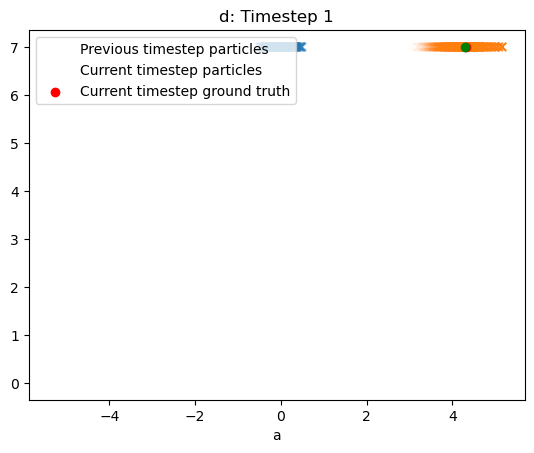

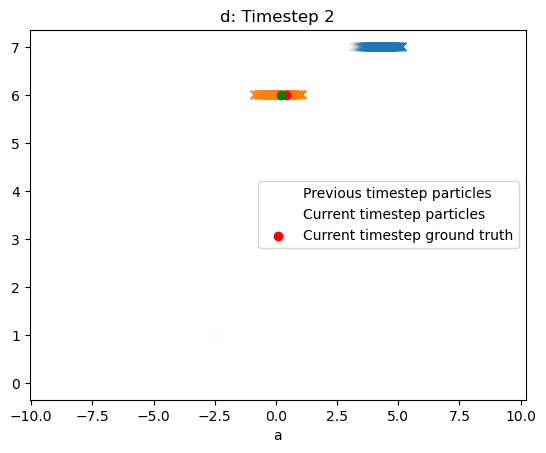

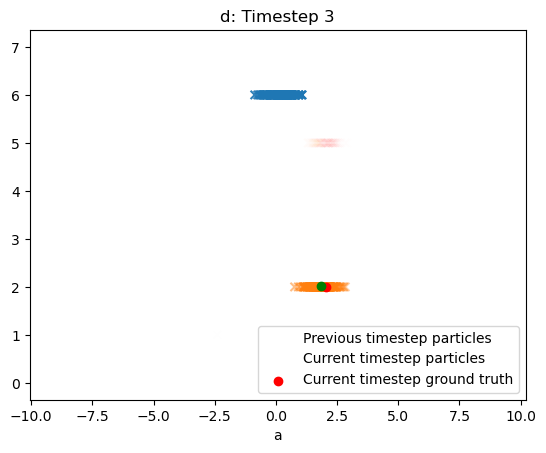

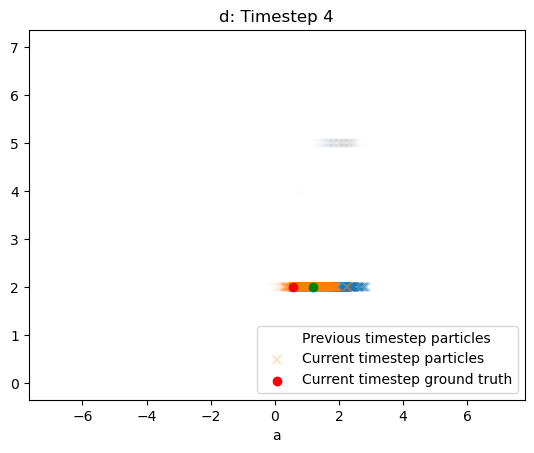

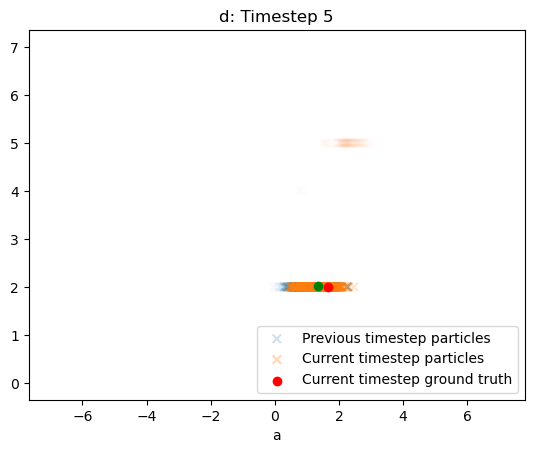

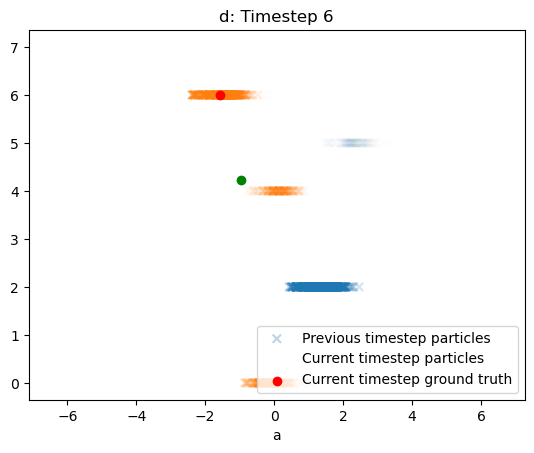

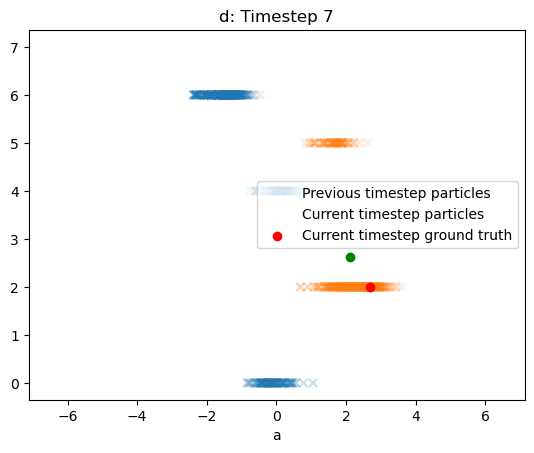

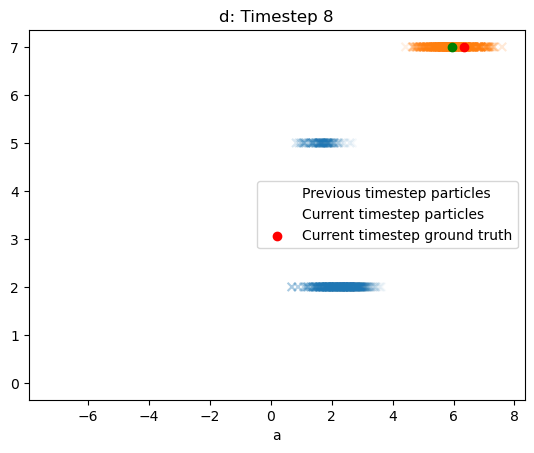

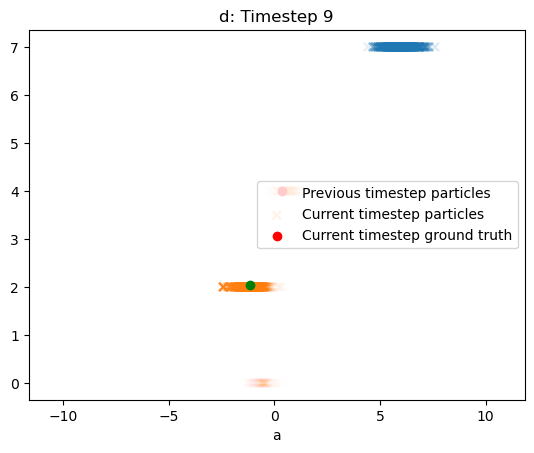

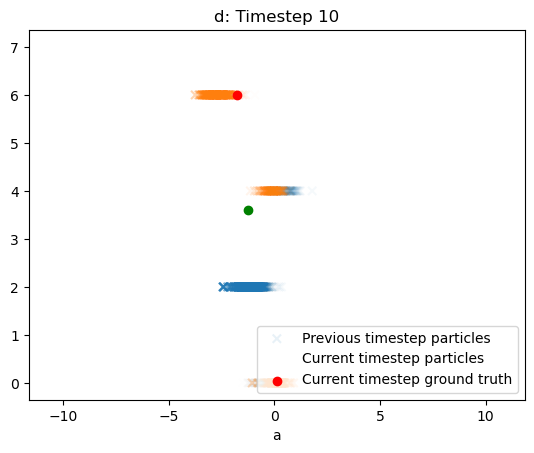

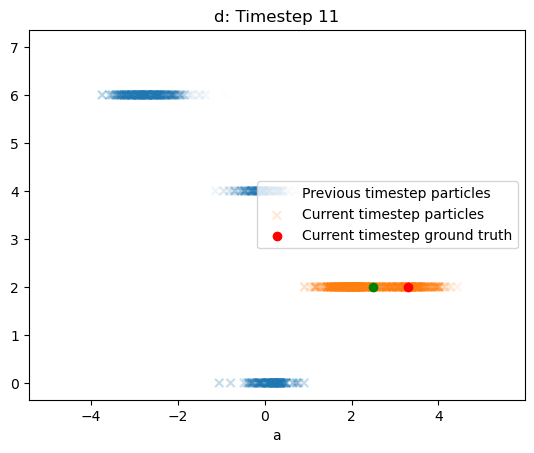

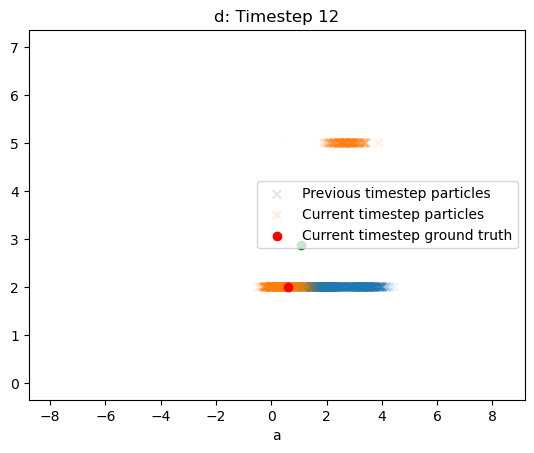

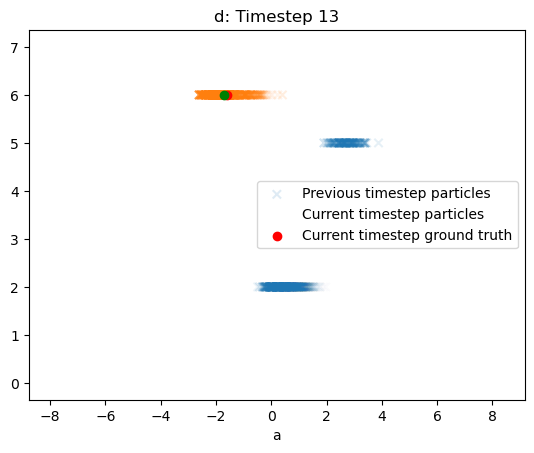

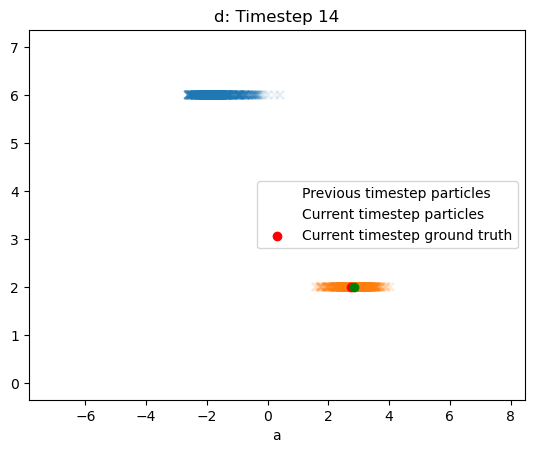

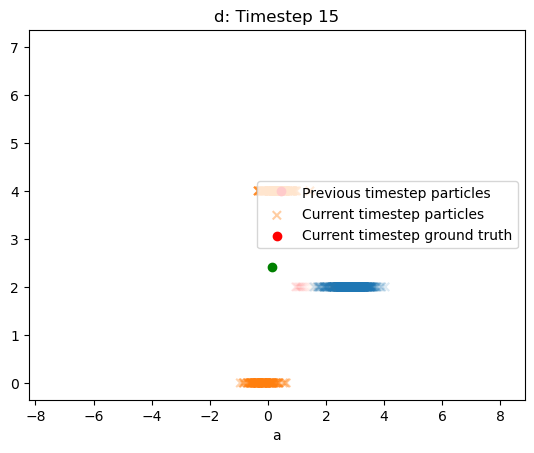

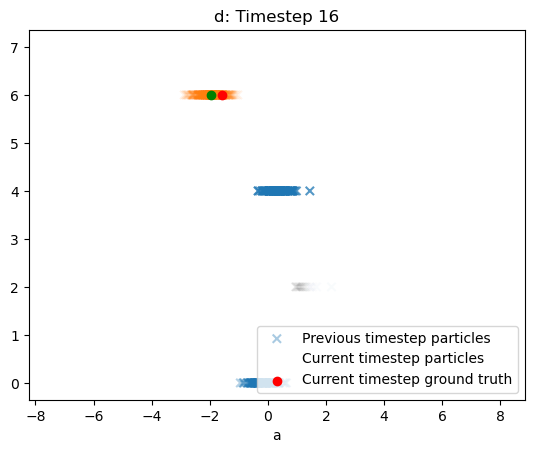

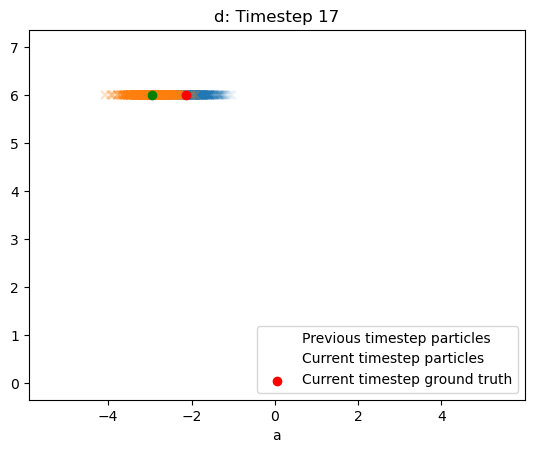

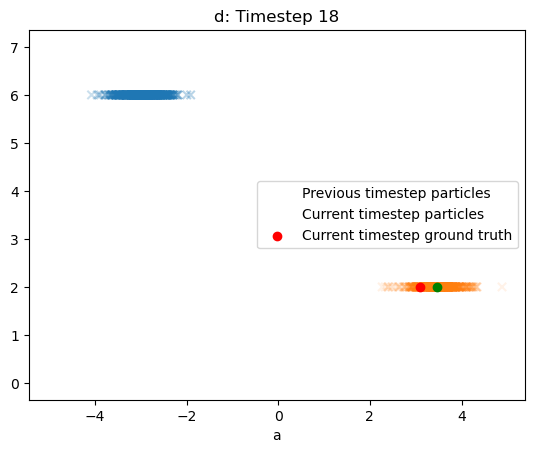

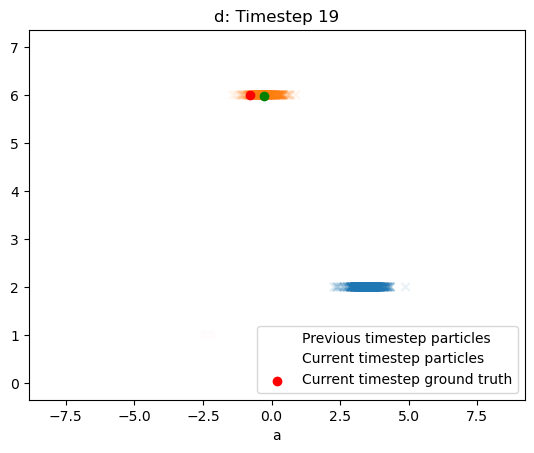

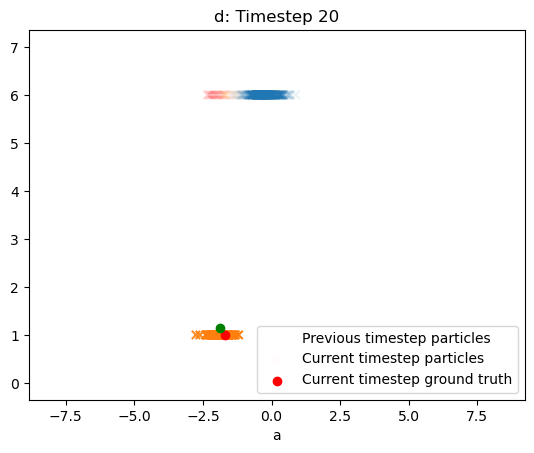

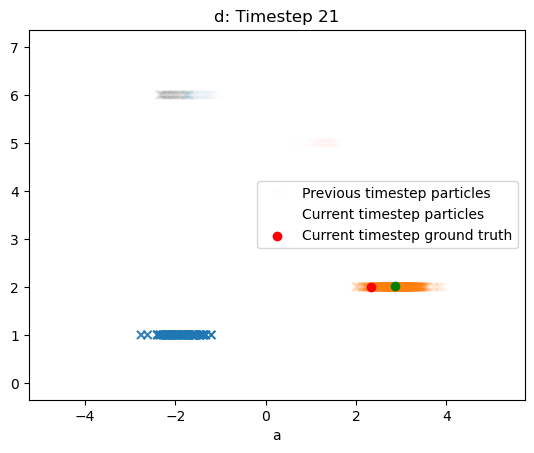

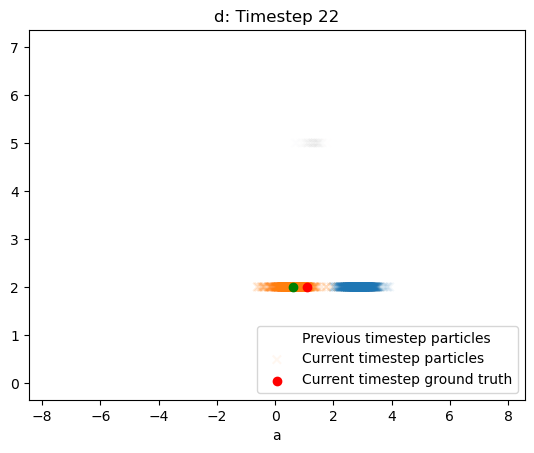

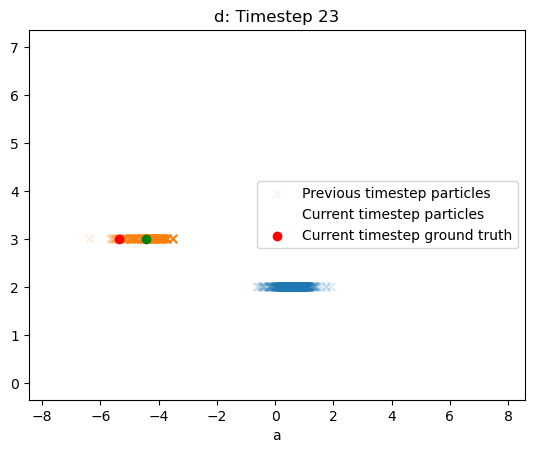

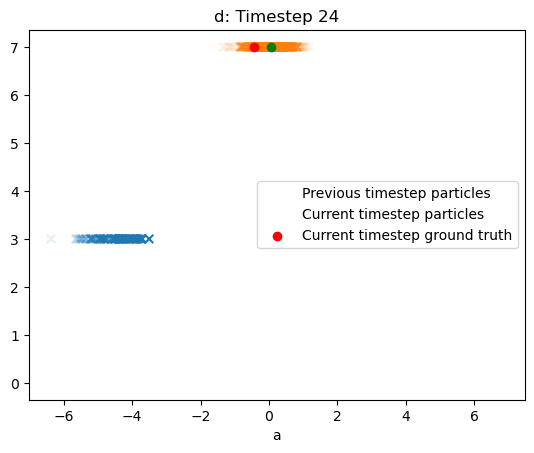

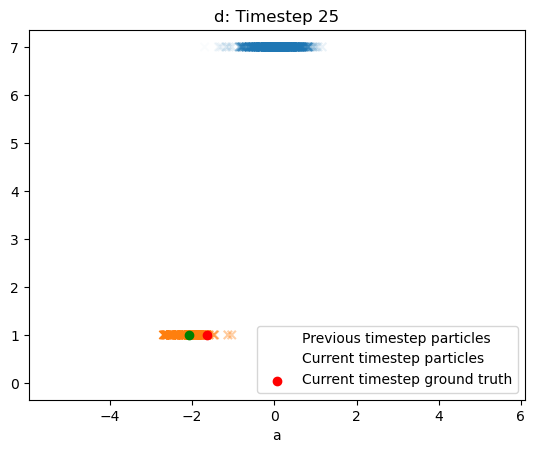

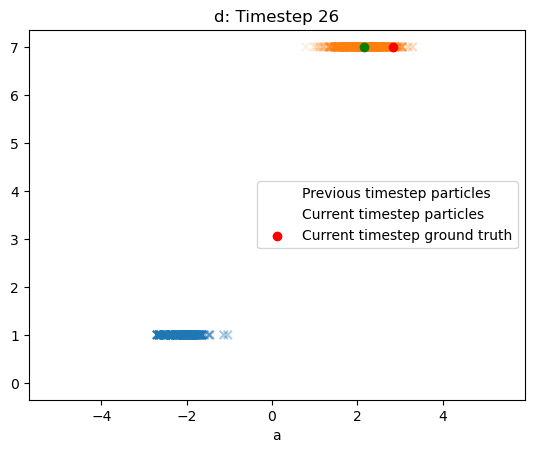

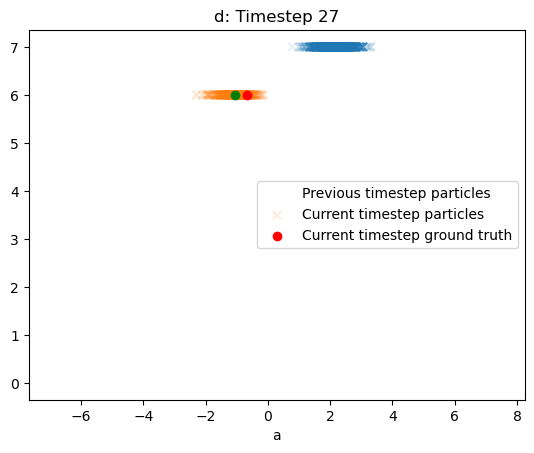

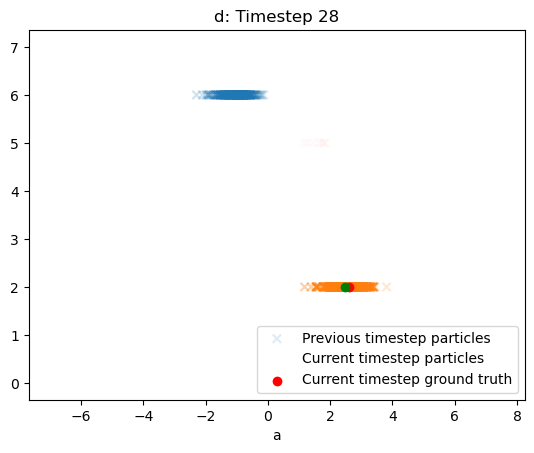

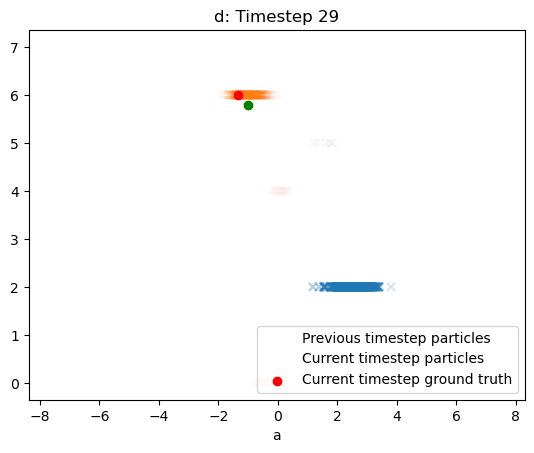

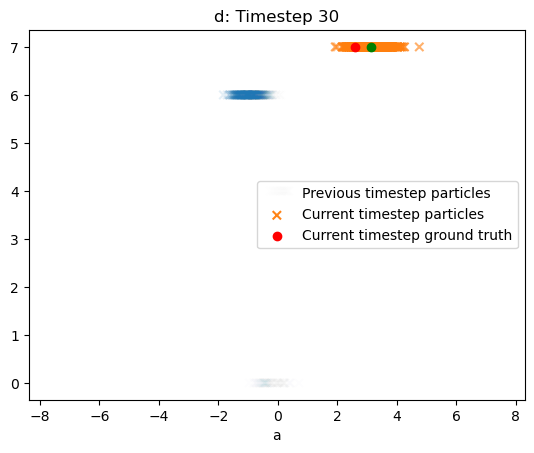

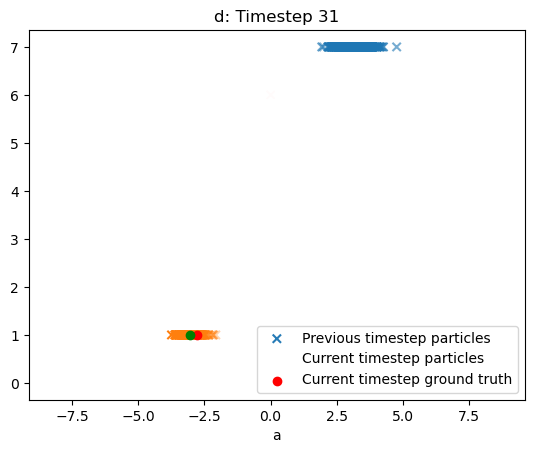

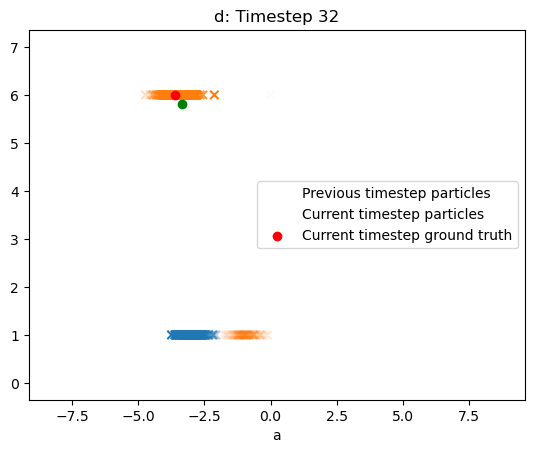

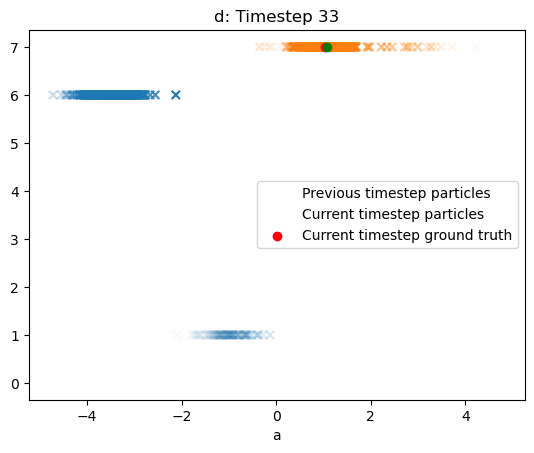

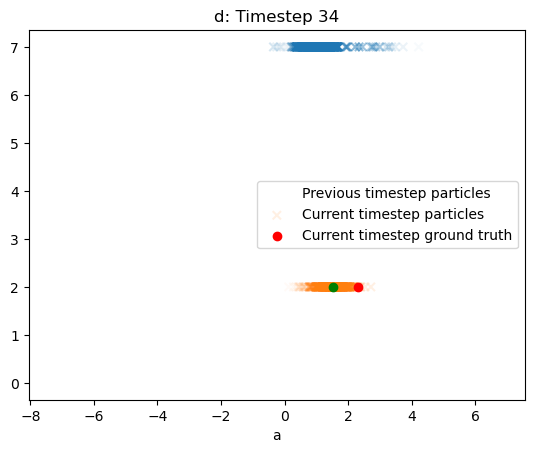

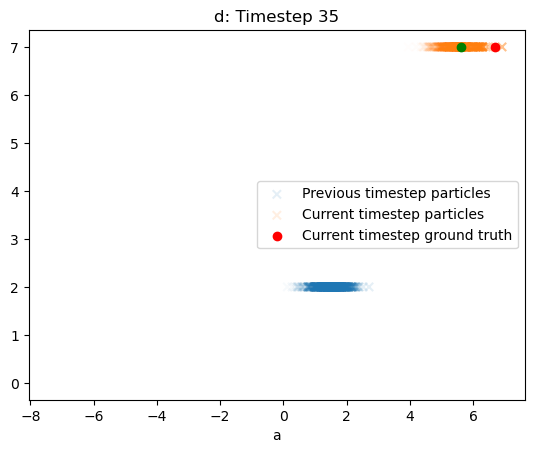

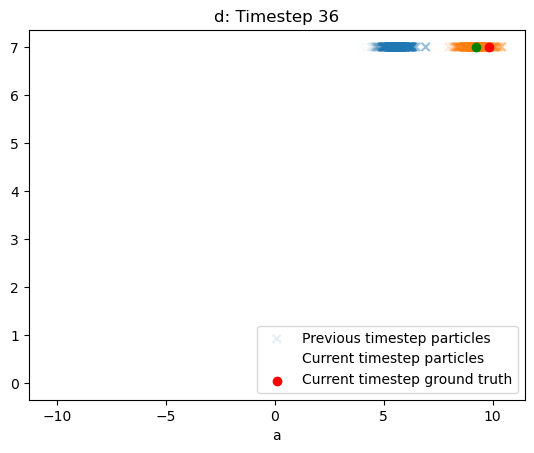

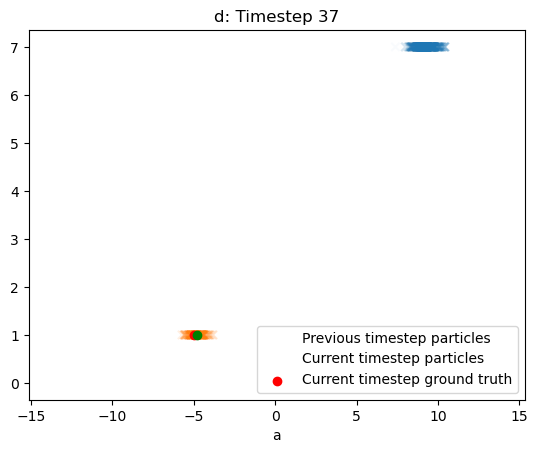

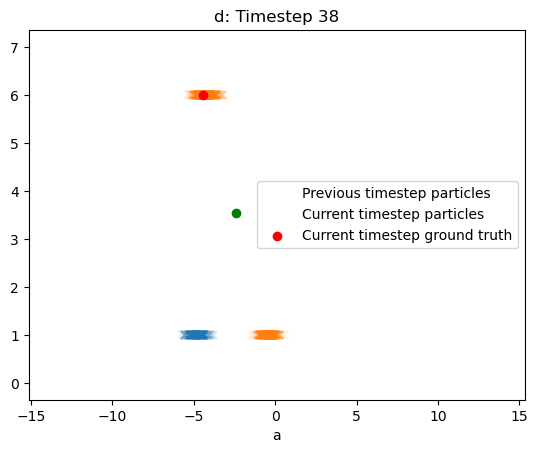

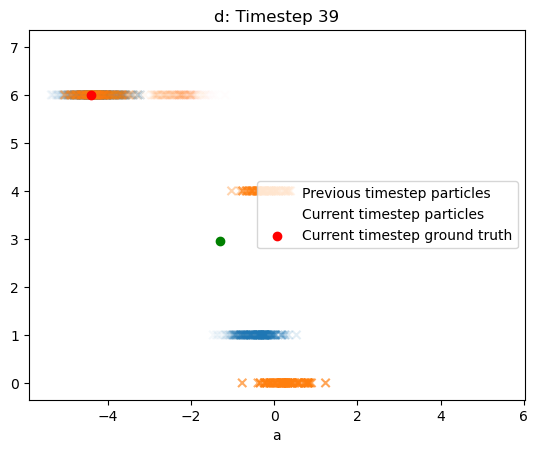

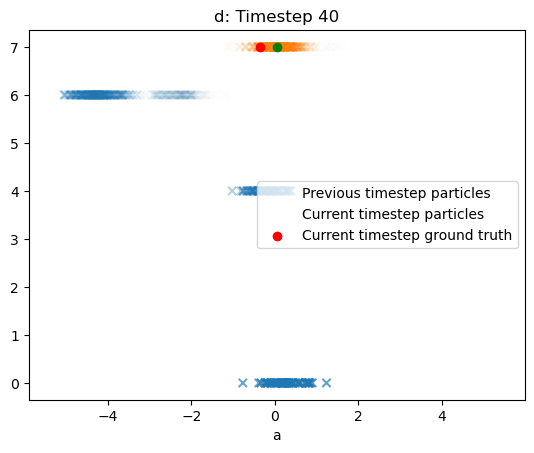

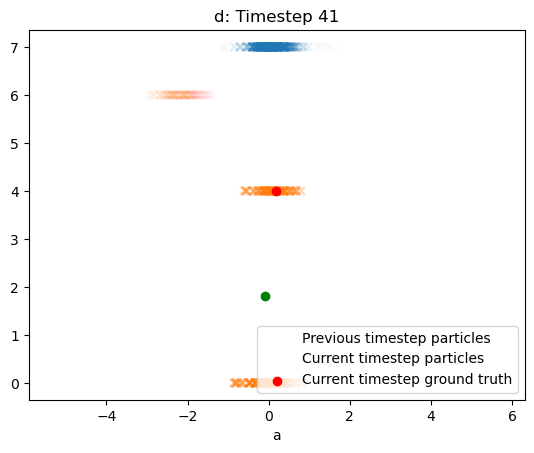

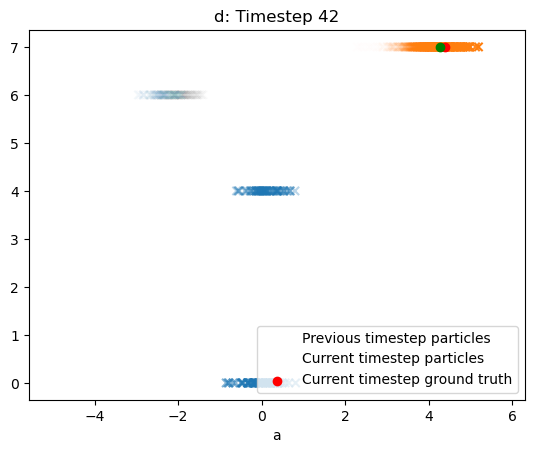

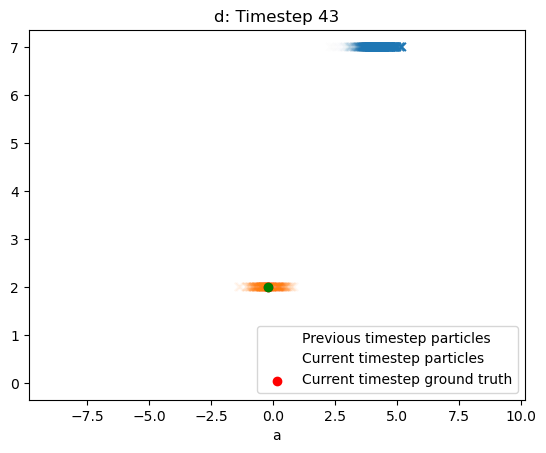

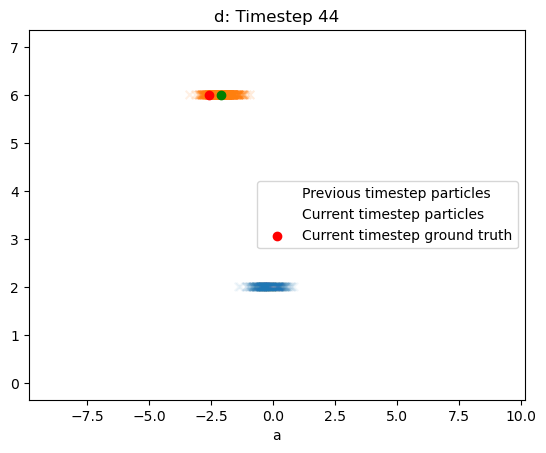

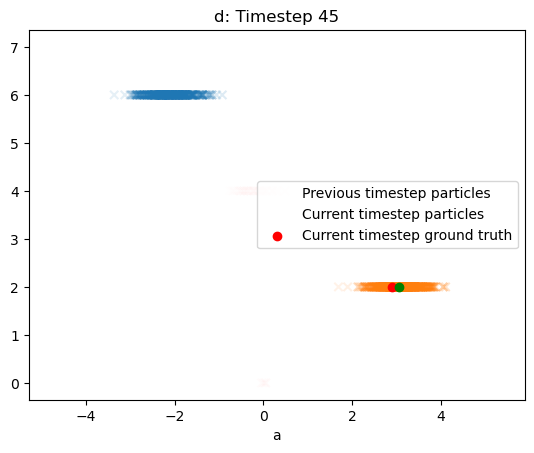

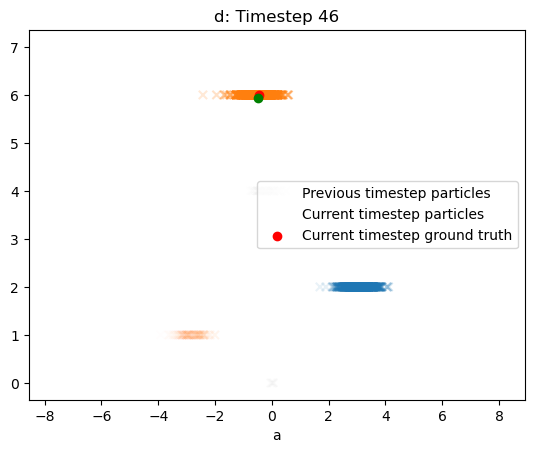

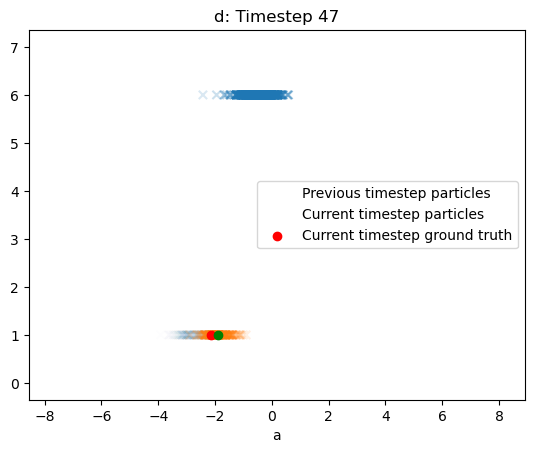

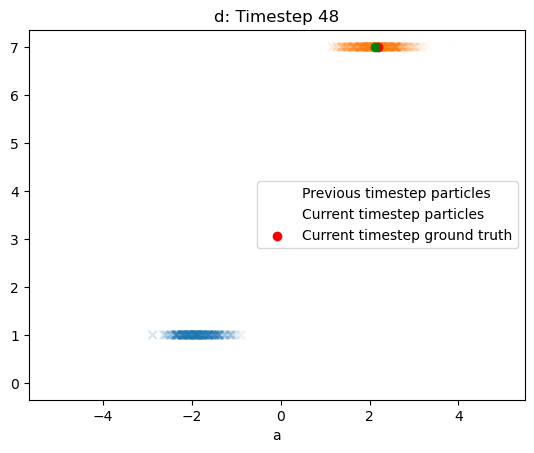

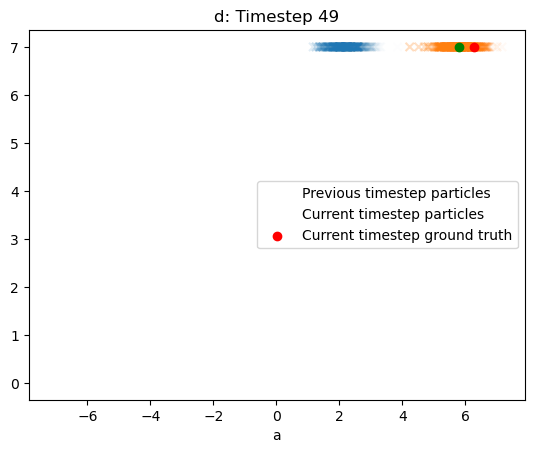

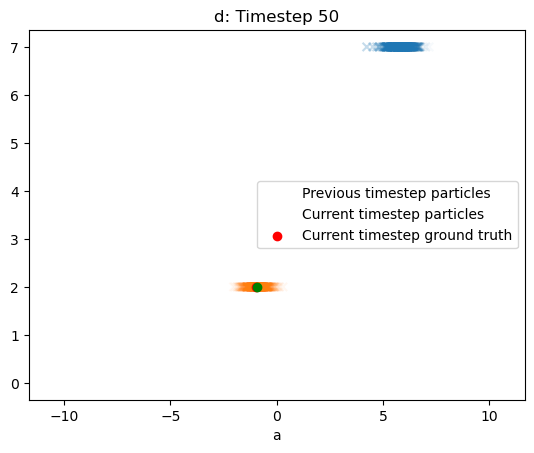

In [13]:
model_ = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
sim_object = model.Simulated_Object(model_, 100, 100, 1, 'cuda')
sim_object.save('./data/temp', 50, 20, '', bypass_ask=True)
data = model.State_Space_Dataset('./data/temp', lazy = True, device='cuda', num_workers=0)
test_model = Net.PF([-0.1, -0.3, -0.5, -0.9, 0.1, 0.3, 0.5, 0.9], [0, -2, 2, -4, 0, 2, -2, 4], 0.1, Net.Polya_Switching(8, 'Boot'), 'Boot', 'cuda')
DPF = simulation.Differentiable_Particle_Filter(test_model, 2000, Soft_Resampler_Systematic(1, 0), 2000, 'cuda')
for i, j in enumerate(pt.utils.data.DataLoader(data, 10, shuffle=True, collate_fn=data.collate)):
    if i == 1:
        break
    DPF.initialise(j)
    DPF.eval()
    DPF.display_particles(50, [0,1], ('a', ''), 'd')